# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import namedtuple
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
EPSILON = 1e-8 # small constant to avoid underflow or divide per 0
%matplotlib inline

# I - Data loading and preprocessing

## Load the data

#### This time, the data will correspond to greyscale images. <br> Two different datasets can be used here:
- The MNIST dataset, small 8*8 images, corresponding to handwritten digits &rightarrow; 10 classes
- The Fashion MNIST dataset, medium 28*28 images, corresponding to clothes pictures &rightarrow; 10 classes

#### Starting with the simple MNIST is recommended

In [2]:
dataset = "MNIST"
# dataset = "FASHION_MNIST"

In [3]:
def load_data(dataset='MNIST'):
    if dataset == 'MNIST':
        digits = load_digits()
        X, Y = np.asarray(digits['data'], dtype='float32'), np.asarray(digits['target'], dtype='int32')
        return X, Y
    elif dataset == 'FASHION_MNIST':
        import tensorflow as tf
        fashion_mnist = tf.keras.datasets.fashion_mnist
        (X, Y), (_, _) = fashion_mnist.load_data()
        X = X.reshape((X.shape[0], X.shape[1] * X.shape[2]))
        X, Y = np.asarray(X, dtype='float32'), np.asarray(Y, dtype='int32')
        return X, Y
X, Y = load_data(dataset=dataset)

In [4]:
n_classes = len(np.unique(Y))

In [5]:
print('Number of samples: {:d}'.format(X.shape[0]))
print('Input dimension: {:d}'.format(X.shape[1]))  # images 8x8 or 28*28 actually
print('Number of classes: {:d}'.format(n_classes))

Number of samples: 1797
Input dimension: 64
Number of classes: 10


In [6]:
print("Range max-min of greyscale pixel values: ({0:.1f}, {1:.1f})".format(np.max(X), np.min(X)))
print("First image sample:\n{0}".format(X[0]))
print("First image label: {0}".format(Y[0]))
print("Input design matrix shape: {0}".format(X.shape))

Range max-min of greyscale pixel values: (16.0, 0.0)
First image sample:
[ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.]
First image label: 0
Input design matrix shape: (1797, 64)


### What does the data look like?
Each image in the dataset consists of a 8 x 8 (or 28 x 28) matrix, of greyscale pixels. For the MNIST dataset, the values are between 0 and 16 where 0 represents white, 16 represents black and there are many shades of grey in-between. For the Fashion MNIST dataset, the values are between 0 and 255.<br>Each image is assigned a corresponding numerical label, so the image in ```X[i]``` has its corresponding label stored in ```Y[i]```.

The next cells below demonstrate how to visualise the input data. Make sure you understand what's happening, particularly how the indices correspond to individual items in the dataset. 

## Visualize the data

In [7]:
def visualize_data_sample(X, Y, nrows=2, ncols=2):
    fig, ax = plt.subplots(nrows, ncols)
    for row in ax:
        for col in row:
            index = random.randint(0, X.shape[0])
            dim = np.sqrt(X.shape[1]).astype(int)
            col.imshow(X[index].reshape((dim, dim)), cmap=plt.cm.gray_r)
            col.set_title("image label: %d" % Y[index])
    plt.tight_layout()
    plt.show()

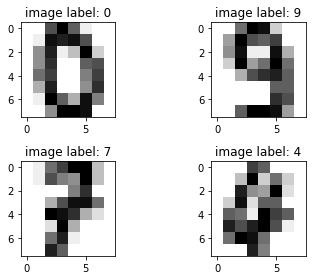

In [8]:
visualize_data_sample(X, Y)

# II - Multiclass classification MLP with Numpy

## II a) - Problem definition

<img src="../images/mlp_mnist.svg">

The task here will be to implement "from scratch" a Multilayer Perceptron for classification.

We will define the formal categorical cross entropy loss as follows:
$$
l(\mathbf{\Theta}, \mathbf{X}, \mathbf{Y}) = - \frac{1}{n} \sum_{i=1}^n \log \mathbf{f}(\mathbf{x}_i ; \mathbf{\Theta})^\top y_i
$$
<center>with $y_i$ being the one-hot encoded true label for the sample $i$, and $\Theta = (\mathbf{W}^h; \mathbf{b}^h; \mathbf{W}^o; \mathbf{b}^o)$</center>
<center>In addition, $\mathbf{f}(\mathbf{x}) = softmax(\mathbf{z^o}(\mathbf{x})) = softmax(\mathbf{W}^o\mathbf{h}(\mathbf{x}) + \mathbf{b}^o)$</center>
<center>and $\mathbf{h}(\mathbf{x}) = g(\mathbf{z^h}(\mathbf{x})) = g(\mathbf{W}^h\mathbf{x} + \mathbf{b}^h)$, $g$ being the activation function and could be implemented with $sigmoid$ or $relu$</center>

## Objectives:
- Write the categorical cross entropy loss function
- Write the activation functions with their associated gradient
- Write the softmax function that is going to be used to output the predicted probabilities
- Implement the forward pass through the neural network
- Implement the backpropagation according to the used loss: progagate the gradients using the chain rule and return $(\mathbf{\nabla_{W^h}}l ; \mathbf{\nabla_{b^h}}l ; \mathbf{\nabla_{W^o}}l ; \mathbf{\nabla_{b^o}}l)$
- Implement dropout regularization in the forward pass: be careful to consider both training and prediction cases
- Implement the SGD optimization algorithm, and improve it with simple momentum

#### Simple graph function to let you have a global overview:

<img src="../images/function_graph.png" style="width: 750px;"/>

### Hints

1) You may find numpy outer products useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.outer.html <br>
We have: $outer(u, v) = u \cdot v^T$, with $u, v$ two vectors

Example:

In [9]:
u, v = np.random.normal(size=(5,)), np.random.normal(size=(10,))
assert np.array_equal(
    np.outer(u, v),
    np.dot(np.reshape(u, (u.size, 1)), np.reshape(v, (1, v.size)))
)
assert np.outer(u, v).shape == (5, 10)

1) You also may find numpy matmul function useful: <br>
https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html <br>
It can be used to perform matrix products along one fixed dimension (i.e. the batch size)

Example:

In [10]:
A, B = np.random.randint(0, 100, size=(64, 5, 10)), np.random.randint(0, 100, size=(64, 10, 5))

In [11]:
assert np.array_equal(
    np.stack([np.dot(A_i, B_i) for A_i, B_i in zip(A, B)]),
    np.matmul(A, B)
)

## II b) - Implementation

In [12]:
class MultiLayerPerceptron():
    """MLP with one hidden layer having a hidden activation,
    and one output layer having a softmax activation"""
    def __init__(self, X, Y, hidden_size, activation='relu',
                 initialization='uniform', dropout=False, dropout_rate=1):
        # input, hidden, and output dimensions on the MLP based on X, Y
        self.input_size, self.output_size = X.shape[1], len(np.unique(Y))
        self.hidden_size = hidden_size
        # initialization strategies: avoid a full-0 initialization of the weight matrices
        if initialization == 'uniform':
            self.W_h = np.random.uniform(size=(self.hidden_size, self.input_size), high=0.01, low=-0.01)
            self.W_o = np.random.uniform(size=(self.output_size, self.hidden_size), high=0.01, low=-0.01)
        elif initialization == 'normal':
            self.W_h = np.random.normal(size=(self.hidden_size, self.input_size), loc=0, scale=0.01)
            self.W_o = np.random.normal(size=(self.output_size, self.hidden_size), loc=0, scale=0.01)
        # the bias could be initializated to 0 or a random low constant
        self.b_h = np.zeros(self.hidden_size)
        self.b_o = np.zeros(self.output_size)
        # our namedtuple structure of gradients
        self.Grads = namedtuple('Grads', ['W_h', 'b_h', 'W_o', 'b_o'])
        # and the velocities associated which are going to be useful for the momentum
        self.velocities = {'W_h': 0., 'b_h': 0., 'W_o': 0., 'b_o': 0.}
        # the hidden activation function used
        self.activation = activation
        # arrays to track back the losses and accuracies evolution
        self.training_losses_history = []
        self.validation_losses_history = []
        self.training_acc_history = []
        self.validation_acc_history = []
        # train val split and normalization of the features
        self.X_tr, self.X_val, self.Y_tr, self.Y_val = self.split_train_validation(X, Y)
        self.scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
        self.X_tr = self.scaler.fit_transform(self.X_tr)
        self.X_val = self.scaler.transform(self.X_val)
        # dropout parameters
        self.dropout = dropout
        self.dropout_rate = dropout_rate
        # step used for the optimization algorithm and setted later
        self.step = None
    
    # One-hot encoding of the target
    # Transform the integer represensation to a sparse one
    @staticmethod
    def one_hot(n_classes, Y):
        return np.eye(n_classes)[Y]
    
    # Reverse one-hot encoding of the target
    # Recover the former integer representation
    # ex: from (0,0,1,0) to 2
    @staticmethod
    def reverse_one_hot(Y_one_hot):
        return np.asarray(np.where(Y_one_hot==1)[1], dtype='int32')
    
    """
    Activation functions and their gradient
    """
    # In implementations below X is a matrix of shape (n_samples, p)
    
    # A max_value value is indicated for the relu and grad_relu functions
    # Make sure to clip the output to it to prevent numerical overflow (exploding gradient)
    # Make it so the max value reachable is max_value
    @staticmethod
    def relu(X, max_value=20):
        assert max_value > 0
        # TODO:
        return np.minimum(np.maximum(X,0), max_value)
    
    # Make it so the gradient becomes 0 when X becomes greater than max_value
    @staticmethod
    def grad_relu(X, max_value=20):
        assert max_value > 0
        # TODO:
        grad = [int(x > 0 and x < max_value) for x in X]
        return grad
    
    @staticmethod
    def sigmoid(X):
        # TODO:
        return 1/(1+np.exp(-X))
    
    def grad_sigmoid(self, X):
        # TODO:
        return self.sigmoid(X) * (1 - self.sigmoid(X))
    
    # Softmax function to output probabilities
    @staticmethod
    def softmax(X):
        # TODO:
        return np.exp(X)/np.sum(np.exp(X), axis=1)
    
    # Loss function
    # Consider using EPSILON to prevent numerical issues (log(0) is undefined)
    # Y_true and Y_pred are of shape (n_samples,n_classes)
    @staticmethod
    def categorical_cross_entropy(Y_true, Y_pred):
        # TODO:
        return -np.mean(np.log(Y_pred+EPSILON)*Y_true)
    
    @staticmethod
    def split_train_validation(X, Y, test_size=0.25, seed=False):
        random_state = 42 if seed else np.random.randint(1e3)
        X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
        return X_tr, X_val, Y_tr, Y_val
    
    # Sample random batch in (X, Y) with a given batch_size for SGD
    @staticmethod
    def get_random_batch(X, Y, batch_size):
        indexes = np.random.choice(X.shape[0], size=batch_size, replace=False)
        return X[indexes], Y[indexes]
        
    # Forward pass: compute f(x) as y, and return optionally the hidden states h(x) and z_h(x) for compute_grads
    def forward(self, X, return_activation=False, training=False):
        if self.activation == 'relu':
            g_activation = self.relu
        elif self.activation == 'sigmoid':
            g_activation = self.sigmoid
        else:
            raise NotImplementedError
        
        z_h = np.dot(X, self.W_h.T) + self.b_h
        h = g_activation(z_h)
        # TODO:
        if self.dropout:
            if training:
                
                h*=np.random.binomial(1, 1-self.dropout_rate, size=h.shape)
                
                pass
            else:
                # TODO:
                h*=(1-self.dropout_rate)
                pass
            
        # TODO:
        y = g_activation(np.dot(h, self.W_o.T) + self.b_o)
        
        if return_activation:
            return y, h, z_h
        else:
            return y
    
    # Backpropagation: return an instantiation of self.Grads that contains the average gradients for the given batch
    def compute_grads(self, X, Y_true, vectorized=False):
        if self.activation == 'relu':
            g_grad = self.grad_relu
        elif self.activation == 'sigmoid':
            g_grad = self.grad_sigmoid
        else:
            raise NotImplementedError
        
        if len(X.shape) == 1:
            print("X format")
            X = X.reshape((1,) + X.shape)
        
        if not vectorized:
            n = X.shape[0]
            grad_W_h = np.zeros((self.hidden_size, self.input_size)) 
            grad_W_o = np.zeros((self.output_size, self.hidden_size))
            grad_b_h = np.zeros((self.hidden_size, ))
            grad_b_o = np.zeros((self.output_size, ))
            
            for x, y_true in zip(X, Y_true):
                y_pred, h, z_h = self.forward(x, return_activation=True, training=True)
                
                # TODO:
                grad_z_o = y_pred - self.one_hot(self.output_size, y_true)
                
                grad_W_o += np.outer(grad_z_o, h)
                grad_b_o += grad_z_o
                grad_h = np.dot(grad_z_o, self.W_o)
                
                grad_z_h = grad_h * g_grad(z_h)
                grad_W_h += np.outer(grad_z_h, x)
                grad_b_h += grad_z_h
                
                
            grads = self.Grads(grad_W_h/n, grad_b_h/n, grad_W_o/n, grad_b_o/n)
            
        else: 
            Y_pred, h, z_h = self.forward(X, return_activation=True, training=True)

            # TODO (optional), try to do the backprop without Python loops in a vectorized way:
#             grad_z_o = Y_pred - self.one_hot(self.output_size, Y_true)
#             #grad_W_o = no sé
#             grad_b_o = grad_z_o
#             grad_h = np.dot(grad_z_o, self.W_o)

#             grad_z_h = grad_h * g_grad(z_h)
#             #grad_W_h = no sé tambien
#             grad_b_h = grad_z_h
            
            
            grads = self.Grads(
                np.mean(grad_W_h, axis=0), 
                np.mean(grad_b_h, axis=0), 
                np.mean(grad_W_o, axis=0), 
                np.mean(grad_b_o, axis=0)
            )
            
        return grads
    
    # Perform the update of the parameters (W_h, b_h, W_o, b_o) based of their gradient
    def optimizer_step(self, optimizer='gd', momentum=False, momentum_alpha=0.9, 
                       batch_size=None, vectorized=True):
        if optimizer == 'gd':
            grads = self.compute_grads(self.X_tr, self.Y_tr, vectorized=vectorized)
        elif optimizer == 'sgd':
            batch_X_tr, batch_Y_tr = self.get_random_batch(self.X_tr, self.Y_tr, batch_size)
            grads = self.compute_grads(batch_X_tr, batch_Y_tr, vectorized=vectorized)
        else:
            raise NotImplementedError
        if not momentum:
            # TODO:
            self.W_h -= self.step * grads.W_h
            self.b_h -= self.step * grads.b_h
            self.W_o -= self.step * grads.W_o
            self.b_o -= self.step * grads.b_o
        else:
            # remember: use the stored velocities
            # TODO:
            self.velocities['W_h'] = momentum_alpha*self.velocities['W_h'] - self.step*grads.W_h
            self.velocities['b_h'] = momentum_alpha*self.velocities['b_h'] - self.step*grads.b_h
            self.velocities['W_o'] = momentum_alpha * self.velocities['W_o'] - self.step * grads.W_o
            self.velocities['b_o'] = momentum_alpha * self.velocities['b_o'] - self.step * grads.b_o
            self.b_o+=self.velocities['b_o']
            self.W_h+=self.velocities['W_h']
            self.W_o+=self.velocities['W_o']
            self.b_h+=self.velocities['b_h']
    
    # Loss wrapper
    def loss(self, Y_true, Y_pred):
        return self.categorical_cross_entropy(self.one_hot(self.output_size, Y_true), Y_pred)
    
    def loss_history_flush(self):
        self.training_losses_history = []
        self.validation_losses_history = []
        
    # Main function that trains the MLP with a design matrix X and a target vector Y
    def train(self, optimizer='sgd', momentum=False, min_iterations=500, max_iterations=5000, initial_step=1e-1,
              batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
              vectorized=False, flush_history=True, verbose=True):
        if flush_history:
            self.loss_history_flush()
        cpt_patience, best_validation_loss = 0, np.inf
        iteration_number = 0
        self.step = initial_step
        while len(self.training_losses_history) < max_iterations:
            iteration_number += 1
            self.optimizer_step(
                optimizer=optimizer, momentum=momentum, batch_size=batch_size, vectorized=vectorized
            )
            
            training_loss = self.loss(self.Y_tr, self.forward(self.X_tr))
            self.training_losses_history.append(training_loss)
            training_accuracy = self.accuracy_on_train()
            self.training_acc_history.append(training_accuracy)
            validation_loss = self.loss(self.Y_val, self.forward(self.X_val))
            self.validation_losses_history.append(validation_loss)
            validation_accuracy = self.accuracy_on_validation()
            self.validation_acc_history.append(validation_accuracy)
            if iteration_number > min_iterations and early_stopping:
                if validation_loss + early_stopping_delta < best_validation_loss:
                    best_validation_loss = validation_loss
                    cpt_patience = 0
                else:
                    cpt_patience += 1
            if verbose:
                msg = "iteration number: {0}\t training loss: {1:.4f}\t" + \
                "validation loss: {2:.4f}\t validation accuracy: {3:.4f}"
                print(msg.format(iteration_number, 
                                 training_loss, 
                                 validation_loss,
                                 validation_accuracy))
            if cpt_patience >= early_stopping_lookbehind:
                break
    
    # Return the predicted class once the MLP has been trained
    def predict(self, X, normalize=True):
        if normalize:
            X = self.scaler.transform(X)
        if len(X.shape) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)
        
    """
    Metrics and plots
    """
    def accuracy_on_train(self):
        return (self.predict(self.X_tr, normalize=False) == self.Y_tr).mean()

    def accuracy_on_validation(self):
        return (self.predict(self.X_val, normalize=False) == self.Y_val).mean()

    def plot_loss_history(self, add_to_title=None):
        import warnings
        warnings.filterwarnings("ignore")
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.training_losses_history)), 
                 self.training_losses_history, label='Training loss evolution')
        plt.plot(range(len(self.validation_losses_history)), 
                 self.validation_losses_history, label='Validation loss evolution')
        plt.legend(fontsize=15)
        plt.yscale('log')
        plt.xlabel("iteration number", fontsize=15)
        plt.ylabel("Cross entropy loss", fontsize=15)
        base_title = "Cross entropy loss evolution during training"
        if not self.dropout:
            base_title += ", no dropout penalization"
        else:
            base_title += ", {:.1f} dropout penalization"
            base_title = base_title.format(self.dropout_rate)
        title = base_title + ", " + add_to_title if add_to_title else base_title
        plt.title(title, fontsize=20)
        plt.show()
        
    def plot_validation_prediction(self, sample_id):
        fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
        classes = np.unique(self.Y_tr)
        dim = np.sqrt(self.X_val.shape[1]).astype(int)
        ax0.imshow(self.scaler.inverse_transform([self.X_val[sample_id]]).reshape(dim, dim), cmap=plt.cm.gray_r,
                   interpolation='nearest')
        ax0.set_title("True image label: %d" % self.Y_val[sample_id]);

        ax1.bar(classes, self.one_hot(len(classes), self.Y_val[sample_id]), label='true')
        ax1.bar(classes, self.forward(self.X_val[sample_id]), label='prediction', color="red")
        ax1.set_xticks(classes)
        prediction = self.predict(self.X_val[sample_id], normalize=False)
        ax1.set_title('Output probabilities (prediction: %d)' % prediction)
        ax1.set_xlabel('Digit class')
        ax1.legend()

In [13]:
mlp = MultiLayerPerceptron(X, Y, hidden_size=50, activation='relu')
mlp.train()

iteration number: 1	 training loss: 0.4654	validation loss: 0.4672	 validation accuracy: 0.1178
iteration number: 2	 training loss: 0.3971	validation loss: 0.3985	 validation accuracy: 0.1578
iteration number: 3	 training loss: 0.3619	validation loss: 0.3633	 validation accuracy: 0.0911
iteration number: 4	 training loss: 0.3365	validation loss: 0.3372	 validation accuracy: 0.1022
iteration number: 5	 training loss: 0.3203	validation loss: 0.3207	 validation accuracy: 0.1400
iteration number: 6	 training loss: 0.3073	validation loss: 0.3077	 validation accuracy: 0.0911
iteration number: 7	 training loss: 0.2958	validation loss: 0.2966	 validation accuracy: 0.0911
iteration number: 8	 training loss: 0.2867	validation loss: 0.2874	 validation accuracy: 0.0911
iteration number: 9	 training loss: 0.2790	validation loss: 0.2794	 validation accuracy: 0.0911
iteration number: 10	 training loss: 0.2726	validation loss: 0.2730	 validation accuracy: 0.1044
iteration number: 11	 training loss: 0.

iteration number: 89	 training loss: 0.2161	validation loss: 0.2166	 validation accuracy: 0.4756
iteration number: 90	 training loss: 0.2156	validation loss: 0.2164	 validation accuracy: 0.4022
iteration number: 91	 training loss: 0.2154	validation loss: 0.2155	 validation accuracy: 0.3800
iteration number: 92	 training loss: 0.2148	validation loss: 0.2151	 validation accuracy: 0.3756
iteration number: 93	 training loss: 0.2145	validation loss: 0.2151	 validation accuracy: 0.3200
iteration number: 94	 training loss: 0.2138	validation loss: 0.2145	 validation accuracy: 0.3400
iteration number: 95	 training loss: 0.2131	validation loss: 0.2136	 validation accuracy: 0.4000
iteration number: 96	 training loss: 0.2125	validation loss: 0.2127	 validation accuracy: 0.4333
iteration number: 97	 training loss: 0.2122	validation loss: 0.2121	 validation accuracy: 0.3911
iteration number: 98	 training loss: 0.2115	validation loss: 0.2115	 validation accuracy: 0.4067
iteration number: 99	 training

iteration number: 174	 training loss: 0.1513	validation loss: 0.1521	 validation accuracy: 0.6022
iteration number: 175	 training loss: 0.1503	validation loss: 0.1525	 validation accuracy: 0.6844
iteration number: 176	 training loss: 0.1499	validation loss: 0.1520	 validation accuracy: 0.7022
iteration number: 177	 training loss: 0.1490	validation loss: 0.1515	 validation accuracy: 0.6778
iteration number: 178	 training loss: 0.1490	validation loss: 0.1518	 validation accuracy: 0.6644
iteration number: 179	 training loss: 0.1476	validation loss: 0.1504	 validation accuracy: 0.6778
iteration number: 180	 training loss: 0.1480	validation loss: 0.1506	 validation accuracy: 0.6556
iteration number: 181	 training loss: 0.1467	validation loss: 0.1494	 validation accuracy: 0.6667
iteration number: 182	 training loss: 0.1449	validation loss: 0.1475	 validation accuracy: 0.6978
iteration number: 183	 training loss: 0.1446	validation loss: 0.1472	 validation accuracy: 0.6889
iteration number: 18

iteration number: 265	 training loss: 0.0929	validation loss: 0.1027	 validation accuracy: 0.8356
iteration number: 266	 training loss: 0.0932	validation loss: 0.1024	 validation accuracy: 0.8511
iteration number: 267	 training loss: 0.0934	validation loss: 0.1058	 validation accuracy: 0.8444
iteration number: 268	 training loss: 0.0930	validation loss: 0.1029	 validation accuracy: 0.8444
iteration number: 269	 training loss: 0.0930	validation loss: 0.1053	 validation accuracy: 0.8489
iteration number: 270	 training loss: 0.0935	validation loss: 0.1055	 validation accuracy: 0.8356
iteration number: 271	 training loss: 0.0920	validation loss: 0.1041	 validation accuracy: 0.8511
iteration number: 272	 training loss: 0.0916	validation loss: 0.1028	 validation accuracy: 0.8511
iteration number: 273	 training loss: 0.0900	validation loss: 0.1021	 validation accuracy: 0.8378
iteration number: 274	 training loss: 0.0896	validation loss: 0.1019	 validation accuracy: 0.8333
iteration number: 27

iteration number: 355	 training loss: 0.0644	validation loss: 0.0764	 validation accuracy: 0.8867
iteration number: 356	 training loss: 0.0632	validation loss: 0.0790	 validation accuracy: 0.8933
iteration number: 357	 training loss: 0.0632	validation loss: 0.0791	 validation accuracy: 0.8889
iteration number: 358	 training loss: 0.0627	validation loss: 0.0779	 validation accuracy: 0.8978
iteration number: 359	 training loss: 0.0624	validation loss: 0.0745	 validation accuracy: 0.9089
iteration number: 360	 training loss: 0.0624	validation loss: 0.0745	 validation accuracy: 0.8978
iteration number: 361	 training loss: 0.0622	validation loss: 0.0767	 validation accuracy: 0.9067
iteration number: 362	 training loss: 0.0597	validation loss: 0.0726	 validation accuracy: 0.9044
iteration number: 363	 training loss: 0.0604	validation loss: 0.0761	 validation accuracy: 0.9022
iteration number: 364	 training loss: 0.0615	validation loss: 0.0739	 validation accuracy: 0.8889
iteration number: 36

iteration number: 440	 training loss: 0.0479	validation loss: 0.0597	 validation accuracy: 0.9244
iteration number: 441	 training loss: 0.0469	validation loss: 0.0589	 validation accuracy: 0.9178
iteration number: 442	 training loss: 0.0469	validation loss: 0.0595	 validation accuracy: 0.9178
iteration number: 443	 training loss: 0.0480	validation loss: 0.0596	 validation accuracy: 0.9200
iteration number: 444	 training loss: 0.0482	validation loss: 0.0604	 validation accuracy: 0.9022
iteration number: 445	 training loss: 0.0481	validation loss: 0.0601	 validation accuracy: 0.9044
iteration number: 446	 training loss: 0.0464	validation loss: 0.0588	 validation accuracy: 0.9200
iteration number: 447	 training loss: 0.0475	validation loss: 0.0616	 validation accuracy: 0.9200
iteration number: 448	 training loss: 0.0479	validation loss: 0.0632	 validation accuracy: 0.9156
iteration number: 449	 training loss: 0.0469	validation loss: 0.0592	 validation accuracy: 0.9133
iteration number: 45

iteration number: 525	 training loss: 0.0382	validation loss: 0.0514	 validation accuracy: 0.9289
iteration number: 526	 training loss: 0.0381	validation loss: 0.0515	 validation accuracy: 0.9267
iteration number: 527	 training loss: 0.0381	validation loss: 0.0513	 validation accuracy: 0.9311
iteration number: 528	 training loss: 0.0384	validation loss: 0.0516	 validation accuracy: 0.9289
iteration number: 529	 training loss: 0.0380	validation loss: 0.0514	 validation accuracy: 0.9267
iteration number: 530	 training loss: 0.0394	validation loss: 0.0561	 validation accuracy: 0.9200
iteration number: 531	 training loss: 0.0384	validation loss: 0.0517	 validation accuracy: 0.9244
iteration number: 532	 training loss: 0.0394	validation loss: 0.0525	 validation accuracy: 0.9267
iteration number: 533	 training loss: 0.0399	validation loss: 0.0524	 validation accuracy: 0.9222
iteration number: 534	 training loss: 0.0404	validation loss: 0.0528	 validation accuracy: 0.9178
iteration number: 53

iteration number: 613	 training loss: 0.0339	validation loss: 0.0478	 validation accuracy: 0.9378
iteration number: 614	 training loss: 0.0341	validation loss: 0.0507	 validation accuracy: 0.9378
iteration number: 615	 training loss: 0.0328	validation loss: 0.0501	 validation accuracy: 0.9422
iteration number: 616	 training loss: 0.0344	validation loss: 0.0513	 validation accuracy: 0.9356
iteration number: 617	 training loss: 0.0347	validation loss: 0.0543	 validation accuracy: 0.9356
iteration number: 618	 training loss: 0.0345	validation loss: 0.0540	 validation accuracy: 0.9311
iteration number: 619	 training loss: 0.0342	validation loss: 0.0508	 validation accuracy: 0.9333
iteration number: 620	 training loss: 0.0330	validation loss: 0.0468	 validation accuracy: 0.9356
iteration number: 621	 training loss: 0.0318	validation loss: 0.0450	 validation accuracy: 0.9356
iteration number: 622	 training loss: 0.0322	validation loss: 0.0454	 validation accuracy: 0.9378
iteration number: 62

iteration number: 701	 training loss: 0.0294	validation loss: 0.0442	 validation accuracy: 0.9311
iteration number: 702	 training loss: 0.0303	validation loss: 0.0490	 validation accuracy: 0.9400
iteration number: 703	 training loss: 0.0293	validation loss: 0.0475	 validation accuracy: 0.9356
iteration number: 704	 training loss: 0.0293	validation loss: 0.0441	 validation accuracy: 0.9378
iteration number: 705	 training loss: 0.0297	validation loss: 0.0453	 validation accuracy: 0.9422
iteration number: 706	 training loss: 0.0316	validation loss: 0.0460	 validation accuracy: 0.9422
iteration number: 707	 training loss: 0.0317	validation loss: 0.0489	 validation accuracy: 0.9400
iteration number: 708	 training loss: 0.0310	validation loss: 0.0480	 validation accuracy: 0.9378
iteration number: 709	 training loss: 0.0309	validation loss: 0.0480	 validation accuracy: 0.9400
iteration number: 710	 training loss: 0.0309	validation loss: 0.0448	 validation accuracy: 0.9400
iteration number: 71

iteration number: 785	 training loss: 0.0293	validation loss: 0.0499	 validation accuracy: 0.9422
iteration number: 786	 training loss: 0.0295	validation loss: 0.0501	 validation accuracy: 0.9422
iteration number: 787	 training loss: 0.0281	validation loss: 0.0424	 validation accuracy: 0.9400
iteration number: 788	 training loss: 0.0287	validation loss: 0.0458	 validation accuracy: 0.9444
iteration number: 789	 training loss: 0.0272	validation loss: 0.0420	 validation accuracy: 0.9400
iteration number: 790	 training loss: 0.0279	validation loss: 0.0460	 validation accuracy: 0.9444
iteration number: 791	 training loss: 0.0270	validation loss: 0.0487	 validation accuracy: 0.9400
iteration number: 792	 training loss: 0.0280	validation loss: 0.0454	 validation accuracy: 0.9400
iteration number: 793	 training loss: 0.0276	validation loss: 0.0455	 validation accuracy: 0.9400
iteration number: 794	 training loss: 0.0271	validation loss: 0.0459	 validation accuracy: 0.9356
iteration number: 79

iteration number: 872	 training loss: 0.0258	validation loss: 0.0401	 validation accuracy: 0.9444
iteration number: 873	 training loss: 0.0271	validation loss: 0.0444	 validation accuracy: 0.9444
iteration number: 874	 training loss: 0.0266	validation loss: 0.0446	 validation accuracy: 0.9422
iteration number: 875	 training loss: 0.0265	validation loss: 0.0445	 validation accuracy: 0.9400
iteration number: 876	 training loss: 0.0266	validation loss: 0.0443	 validation accuracy: 0.9400
iteration number: 877	 training loss: 0.0266	validation loss: 0.0446	 validation accuracy: 0.9444
iteration number: 878	 training loss: 0.0254	validation loss: 0.0444	 validation accuracy: 0.9444
iteration number: 879	 training loss: 0.0256	validation loss: 0.0446	 validation accuracy: 0.9444
iteration number: 880	 training loss: 0.0273	validation loss: 0.0486	 validation accuracy: 0.9422
iteration number: 881	 training loss: 0.0265	validation loss: 0.0484	 validation accuracy: 0.9422
iteration number: 88

iteration number: 963	 training loss: 0.0238	validation loss: 0.0394	 validation accuracy: 0.9533
iteration number: 964	 training loss: 0.0239	validation loss: 0.0427	 validation accuracy: 0.9533
iteration number: 965	 training loss: 0.0238	validation loss: 0.0423	 validation accuracy: 0.9511
iteration number: 966	 training loss: 0.0232	validation loss: 0.0423	 validation accuracy: 0.9533
iteration number: 967	 training loss: 0.0255	validation loss: 0.0428	 validation accuracy: 0.9533
iteration number: 968	 training loss: 0.0247	validation loss: 0.0430	 validation accuracy: 0.9556
iteration number: 969	 training loss: 0.0244	validation loss: 0.0424	 validation accuracy: 0.9556
iteration number: 970	 training loss: 0.0243	validation loss: 0.0425	 validation accuracy: 0.9533
iteration number: 971	 training loss: 0.0240	validation loss: 0.0424	 validation accuracy: 0.9556
iteration number: 972	 training loss: 0.0241	validation loss: 0.0426	 validation accuracy: 0.9533
iteration number: 97

iteration number: 1053	 training loss: 0.0210	validation loss: 0.0373	 validation accuracy: 0.9556
iteration number: 1054	 training loss: 0.0211	validation loss: 0.0375	 validation accuracy: 0.9556
iteration number: 1055	 training loss: 0.0226	validation loss: 0.0414	 validation accuracy: 0.9489
iteration number: 1056	 training loss: 0.0241	validation loss: 0.0422	 validation accuracy: 0.9489
iteration number: 1057	 training loss: 0.0241	validation loss: 0.0422	 validation accuracy: 0.9489
iteration number: 1058	 training loss: 0.0227	validation loss: 0.0386	 validation accuracy: 0.9489
iteration number: 1059	 training loss: 0.0224	validation loss: 0.0380	 validation accuracy: 0.9533
iteration number: 1060	 training loss: 0.0239	validation loss: 0.0421	 validation accuracy: 0.9533
iteration number: 1061	 training loss: 0.0233	validation loss: 0.0422	 validation accuracy: 0.9533
iteration number: 1062	 training loss: 0.0231	validation loss: 0.0450	 validation accuracy: 0.9556
iteration 

iteration number: 1143	 training loss: 0.0207	validation loss: 0.0370	 validation accuracy: 0.9578
iteration number: 1144	 training loss: 0.0215	validation loss: 0.0405	 validation accuracy: 0.9578
iteration number: 1145	 training loss: 0.0213	validation loss: 0.0370	 validation accuracy: 0.9556
iteration number: 1146	 training loss: 0.0212	validation loss: 0.0370	 validation accuracy: 0.9578
iteration number: 1147	 training loss: 0.0217	validation loss: 0.0403	 validation accuracy: 0.9556
iteration number: 1148	 training loss: 0.0215	validation loss: 0.0373	 validation accuracy: 0.9578
iteration number: 1149	 training loss: 0.0217	validation loss: 0.0405	 validation accuracy: 0.9533
iteration number: 1150	 training loss: 0.0214	validation loss: 0.0334	 validation accuracy: 0.9556
iteration number: 1151	 training loss: 0.0210	validation loss: 0.0376	 validation accuracy: 0.9600
iteration number: 1152	 training loss: 0.0208	validation loss: 0.0379	 validation accuracy: 0.9600
iteration 

iteration number: 1228	 training loss: 0.0205	validation loss: 0.0439	 validation accuracy: 0.9600
iteration number: 1229	 training loss: 0.0192	validation loss: 0.0437	 validation accuracy: 0.9578
iteration number: 1230	 training loss: 0.0203	validation loss: 0.0403	 validation accuracy: 0.9578
iteration number: 1231	 training loss: 0.0223	validation loss: 0.0402	 validation accuracy: 0.9578
iteration number: 1232	 training loss: 0.0194	validation loss: 0.0361	 validation accuracy: 0.9600
iteration number: 1233	 training loss: 0.0210	validation loss: 0.0366	 validation accuracy: 0.9600
iteration number: 1234	 training loss: 0.0210	validation loss: 0.0367	 validation accuracy: 0.9600
iteration number: 1235	 training loss: 0.0219	validation loss: 0.0401	 validation accuracy: 0.9622
iteration number: 1236	 training loss: 0.0221	validation loss: 0.0407	 validation accuracy: 0.9533
iteration number: 1237	 training loss: 0.0222	validation loss: 0.0410	 validation accuracy: 0.9533
iteration 

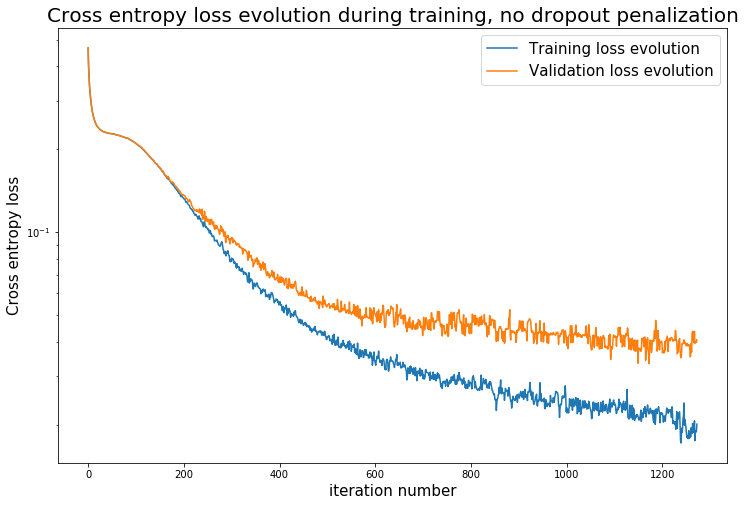

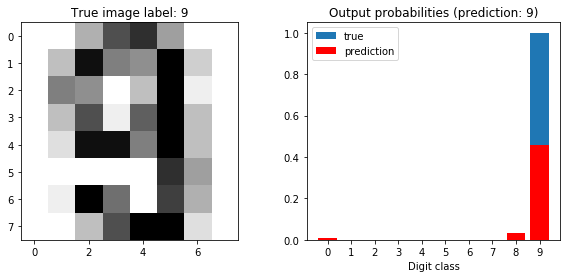

In [14]:
mlp.plot_loss_history()
mlp.plot_validation_prediction(12)

In [15]:
mlp2 = MultiLayerPerceptron(X, Y, hidden_size=50, activation='sigmoid')
mlp2.train(momentum=False, min_iterations=500, max_iterations=1500, initial_step=1e-1,
              batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
              vectorized=False, flush_history=True, verbose=True)

iteration number: 1	 training loss: 0.1001	validation loss: 0.1002	 validation accuracy: 0.0978
iteration number: 2	 training loss: 0.1248	validation loss: 0.1252	 validation accuracy: 0.0978
iteration number: 3	 training loss: 0.1445	validation loss: 0.1450	 validation accuracy: 0.0978
iteration number: 4	 training loss: 0.1601	validation loss: 0.1606	 validation accuracy: 0.0822
iteration number: 5	 training loss: 0.1725	validation loss: 0.1730	 validation accuracy: 0.0822
iteration number: 6	 training loss: 0.1826	validation loss: 0.1832	 validation accuracy: 0.0822
iteration number: 7	 training loss: 0.1907	validation loss: 0.1913	 validation accuracy: 0.0822
iteration number: 8	 training loss: 0.1974	validation loss: 0.1980	 validation accuracy: 0.0822
iteration number: 9	 training loss: 0.2028	validation loss: 0.2034	 validation accuracy: 0.0822
iteration number: 10	 training loss: 0.2074	validation loss: 0.2078	 validation accuracy: 0.0956
iteration number: 11	 training loss: 0.

iteration number: 91	 training loss: 0.2306	validation loss: 0.2311	 validation accuracy: 0.1044
iteration number: 92	 training loss: 0.2306	validation loss: 0.2310	 validation accuracy: 0.1044
iteration number: 93	 training loss: 0.2306	validation loss: 0.2308	 validation accuracy: 0.1000
iteration number: 94	 training loss: 0.2304	validation loss: 0.2311	 validation accuracy: 0.0956
iteration number: 95	 training loss: 0.2303	validation loss: 0.2313	 validation accuracy: 0.0822
iteration number: 96	 training loss: 0.2303	validation loss: 0.2311	 validation accuracy: 0.0822
iteration number: 97	 training loss: 0.2302	validation loss: 0.2313	 validation accuracy: 0.0822
iteration number: 98	 training loss: 0.2302	validation loss: 0.2312	 validation accuracy: 0.0822
iteration number: 99	 training loss: 0.2302	validation loss: 0.2311	 validation accuracy: 0.0822
iteration number: 100	 training loss: 0.2302	validation loss: 0.2310	 validation accuracy: 0.0822
iteration number: 101	 traini

iteration number: 178	 training loss: 0.2305	validation loss: 0.2312	 validation accuracy: 0.0956
iteration number: 179	 training loss: 0.2305	validation loss: 0.2313	 validation accuracy: 0.0956
iteration number: 180	 training loss: 0.2305	validation loss: 0.2314	 validation accuracy: 0.0956
iteration number: 181	 training loss: 0.2305	validation loss: 0.2315	 validation accuracy: 0.1689
iteration number: 182	 training loss: 0.2305	validation loss: 0.2314	 validation accuracy: 0.1711
iteration number: 183	 training loss: 0.2305	validation loss: 0.2311	 validation accuracy: 0.1711
iteration number: 184	 training loss: 0.2305	validation loss: 0.2311	 validation accuracy: 0.0867
iteration number: 185	 training loss: 0.2305	validation loss: 0.2310	 validation accuracy: 0.0867
iteration number: 186	 training loss: 0.2305	validation loss: 0.2309	 validation accuracy: 0.0867
iteration number: 187	 training loss: 0.2305	validation loss: 0.2310	 validation accuracy: 0.0867
iteration number: 18

iteration number: 265	 training loss: 0.2302	validation loss: 0.2310	 validation accuracy: 0.0822
iteration number: 266	 training loss: 0.2302	validation loss: 0.2309	 validation accuracy: 0.0822
iteration number: 267	 training loss: 0.2302	validation loss: 0.2308	 validation accuracy: 0.0822
iteration number: 268	 training loss: 0.2302	validation loss: 0.2310	 validation accuracy: 0.0822
iteration number: 269	 training loss: 0.2302	validation loss: 0.2310	 validation accuracy: 0.0822
iteration number: 270	 training loss: 0.2302	validation loss: 0.2310	 validation accuracy: 0.0822
iteration number: 271	 training loss: 0.2302	validation loss: 0.2311	 validation accuracy: 0.0822
iteration number: 272	 training loss: 0.2302	validation loss: 0.2310	 validation accuracy: 0.0822
iteration number: 273	 training loss: 0.2300	validation loss: 0.2312	 validation accuracy: 0.0822
iteration number: 274	 training loss: 0.2300	validation loss: 0.2312	 validation accuracy: 0.0867
iteration number: 27

iteration number: 359	 training loss: 0.2299	validation loss: 0.2310	 validation accuracy: 0.0978
iteration number: 360	 training loss: 0.2298	validation loss: 0.2314	 validation accuracy: 0.0822
iteration number: 361	 training loss: 0.2298	validation loss: 0.2313	 validation accuracy: 0.0822
iteration number: 362	 training loss: 0.2299	validation loss: 0.2313	 validation accuracy: 0.0822
iteration number: 363	 training loss: 0.2299	validation loss: 0.2313	 validation accuracy: 0.0822
iteration number: 364	 training loss: 0.2299	validation loss: 0.2312	 validation accuracy: 0.0822
iteration number: 365	 training loss: 0.2299	validation loss: 0.2310	 validation accuracy: 0.0822
iteration number: 366	 training loss: 0.2296	validation loss: 0.2313	 validation accuracy: 0.0822
iteration number: 367	 training loss: 0.2296	validation loss: 0.2315	 validation accuracy: 0.0822
iteration number: 368	 training loss: 0.2296	validation loss: 0.2319	 validation accuracy: 0.0822
iteration number: 36

iteration number: 444	 training loss: 0.2288	validation loss: 0.2288	 validation accuracy: 0.0822
iteration number: 445	 training loss: 0.2289	validation loss: 0.2289	 validation accuracy: 0.0822
iteration number: 446	 training loss: 0.2288	validation loss: 0.2292	 validation accuracy: 0.0822
iteration number: 447	 training loss: 0.2287	validation loss: 0.2295	 validation accuracy: 0.0822
iteration number: 448	 training loss: 0.2288	validation loss: 0.2292	 validation accuracy: 0.0822
iteration number: 449	 training loss: 0.2286	validation loss: 0.2295	 validation accuracy: 0.0822
iteration number: 450	 training loss: 0.2287	validation loss: 0.2293	 validation accuracy: 0.1356
iteration number: 451	 training loss: 0.2288	validation loss: 0.2292	 validation accuracy: 0.1089
iteration number: 452	 training loss: 0.2289	validation loss: 0.2288	 validation accuracy: 0.0911
iteration number: 453	 training loss: 0.2289	validation loss: 0.2289	 validation accuracy: 0.1778
iteration number: 45

iteration number: 528	 training loss: 0.2261	validation loss: 0.2263	 validation accuracy: 0.2000
iteration number: 529	 training loss: 0.2260	validation loss: 0.2264	 validation accuracy: 0.1867
iteration number: 530	 training loss: 0.2259	validation loss: 0.2263	 validation accuracy: 0.1867
iteration number: 531	 training loss: 0.2258	validation loss: 0.2263	 validation accuracy: 0.1711
iteration number: 532	 training loss: 0.2258	validation loss: 0.2261	 validation accuracy: 0.1356
iteration number: 533	 training loss: 0.2259	validation loss: 0.2258	 validation accuracy: 0.2200
iteration number: 534	 training loss: 0.2257	validation loss: 0.2258	 validation accuracy: 0.1133
iteration number: 535	 training loss: 0.2257	validation loss: 0.2256	 validation accuracy: 0.2067
iteration number: 536	 training loss: 0.2256	validation loss: 0.2256	 validation accuracy: 0.1889
iteration number: 537	 training loss: 0.2256	validation loss: 0.2257	 validation accuracy: 0.2489
iteration number: 53

iteration number: 613	 training loss: 0.2197	validation loss: 0.2207	 validation accuracy: 0.1778
iteration number: 614	 training loss: 0.2197	validation loss: 0.2203	 validation accuracy: 0.3244
iteration number: 615	 training loss: 0.2196	validation loss: 0.2205	 validation accuracy: 0.1778
iteration number: 616	 training loss: 0.2194	validation loss: 0.2208	 validation accuracy: 0.1822
iteration number: 617	 training loss: 0.2194	validation loss: 0.2206	 validation accuracy: 0.2444
iteration number: 618	 training loss: 0.2192	validation loss: 0.2206	 validation accuracy: 0.1733
iteration number: 619	 training loss: 0.2191	validation loss: 0.2205	 validation accuracy: 0.2467
iteration number: 620	 training loss: 0.2192	validation loss: 0.2201	 validation accuracy: 0.2844
iteration number: 621	 training loss: 0.2190	validation loss: 0.2201	 validation accuracy: 0.2378
iteration number: 622	 training loss: 0.2189	validation loss: 0.2200	 validation accuracy: 0.2311
iteration number: 62

iteration number: 706	 training loss: 0.2068	validation loss: 0.2065	 validation accuracy: 0.4133
iteration number: 707	 training loss: 0.2066	validation loss: 0.2065	 validation accuracy: 0.3600
iteration number: 708	 training loss: 0.2064	validation loss: 0.2063	 validation accuracy: 0.3600
iteration number: 709	 training loss: 0.2062	validation loss: 0.2061	 validation accuracy: 0.3778
iteration number: 710	 training loss: 0.2060	validation loss: 0.2061	 validation accuracy: 0.3578
iteration number: 711	 training loss: 0.2057	validation loss: 0.2061	 validation accuracy: 0.3089
iteration number: 712	 training loss: 0.2058	validation loss: 0.2057	 validation accuracy: 0.3511
iteration number: 713	 training loss: 0.2054	validation loss: 0.2055	 validation accuracy: 0.3711
iteration number: 714	 training loss: 0.2053	validation loss: 0.2051	 validation accuracy: 0.3556
iteration number: 715	 training loss: 0.2051	validation loss: 0.2050	 validation accuracy: 0.4133
iteration number: 71

iteration number: 793	 training loss: 0.1890	validation loss: 0.1883	 validation accuracy: 0.4956
iteration number: 794	 training loss: 0.1892	validation loss: 0.1882	 validation accuracy: 0.4733
iteration number: 795	 training loss: 0.1891	validation loss: 0.1883	 validation accuracy: 0.4778
iteration number: 796	 training loss: 0.1887	validation loss: 0.1876	 validation accuracy: 0.5267
iteration number: 797	 training loss: 0.1884	validation loss: 0.1878	 validation accuracy: 0.4556
iteration number: 798	 training loss: 0.1882	validation loss: 0.1875	 validation accuracy: 0.4622
iteration number: 799	 training loss: 0.1877	validation loss: 0.1871	 validation accuracy: 0.4489
iteration number: 800	 training loss: 0.1873	validation loss: 0.1873	 validation accuracy: 0.4289
iteration number: 801	 training loss: 0.1868	validation loss: 0.1865	 validation accuracy: 0.5200
iteration number: 802	 training loss: 0.1864	validation loss: 0.1865	 validation accuracy: 0.5644
iteration number: 80

iteration number: 881	 training loss: 0.1683	validation loss: 0.1679	 validation accuracy: 0.6156
iteration number: 882	 training loss: 0.1683	validation loss: 0.1677	 validation accuracy: 0.6422
iteration number: 883	 training loss: 0.1683	validation loss: 0.1675	 validation accuracy: 0.5889
iteration number: 884	 training loss: 0.1682	validation loss: 0.1675	 validation accuracy: 0.6000
iteration number: 885	 training loss: 0.1681	validation loss: 0.1677	 validation accuracy: 0.5756
iteration number: 886	 training loss: 0.1681	validation loss: 0.1675	 validation accuracy: 0.5578
iteration number: 887	 training loss: 0.1678	validation loss: 0.1672	 validation accuracy: 0.5511
iteration number: 888	 training loss: 0.1669	validation loss: 0.1665	 validation accuracy: 0.6111
iteration number: 889	 training loss: 0.1672	validation loss: 0.1668	 validation accuracy: 0.6267
iteration number: 890	 training loss: 0.1668	validation loss: 0.1662	 validation accuracy: 0.6200
iteration number: 89

iteration number: 970	 training loss: 0.1520	validation loss: 0.1508	 validation accuracy: 0.6778
iteration number: 971	 training loss: 0.1524	validation loss: 0.1510	 validation accuracy: 0.6711
iteration number: 972	 training loss: 0.1518	validation loss: 0.1504	 validation accuracy: 0.6667
iteration number: 973	 training loss: 0.1512	validation loss: 0.1500	 validation accuracy: 0.6956
iteration number: 974	 training loss: 0.1512	validation loss: 0.1499	 validation accuracy: 0.6956
iteration number: 975	 training loss: 0.1507	validation loss: 0.1493	 validation accuracy: 0.6911
iteration number: 976	 training loss: 0.1503	validation loss: 0.1487	 validation accuracy: 0.7133
iteration number: 977	 training loss: 0.1498	validation loss: 0.1484	 validation accuracy: 0.7022
iteration number: 978	 training loss: 0.1494	validation loss: 0.1480	 validation accuracy: 0.7067
iteration number: 979	 training loss: 0.1491	validation loss: 0.1479	 validation accuracy: 0.7044
iteration number: 98

iteration number: 1057	 training loss: 0.1364	validation loss: 0.1341	 validation accuracy: 0.7644
iteration number: 1058	 training loss: 0.1357	validation loss: 0.1335	 validation accuracy: 0.7667
iteration number: 1059	 training loss: 0.1354	validation loss: 0.1333	 validation accuracy: 0.7822
iteration number: 1060	 training loss: 0.1347	validation loss: 0.1326	 validation accuracy: 0.7689
iteration number: 1061	 training loss: 0.1340	validation loss: 0.1323	 validation accuracy: 0.7444
iteration number: 1062	 training loss: 0.1339	validation loss: 0.1325	 validation accuracy: 0.7578
iteration number: 1063	 training loss: 0.1343	validation loss: 0.1328	 validation accuracy: 0.7689
iteration number: 1064	 training loss: 0.1340	validation loss: 0.1325	 validation accuracy: 0.7778
iteration number: 1065	 training loss: 0.1335	validation loss: 0.1318	 validation accuracy: 0.7733
iteration number: 1066	 training loss: 0.1337	validation loss: 0.1319	 validation accuracy: 0.7556
iteration 

iteration number: 1145	 training loss: 0.1224	validation loss: 0.1210	 validation accuracy: 0.7733
iteration number: 1146	 training loss: 0.1215	validation loss: 0.1201	 validation accuracy: 0.7911
iteration number: 1147	 training loss: 0.1217	validation loss: 0.1201	 validation accuracy: 0.7978
iteration number: 1148	 training loss: 0.1210	validation loss: 0.1195	 validation accuracy: 0.7844
iteration number: 1149	 training loss: 0.1216	validation loss: 0.1202	 validation accuracy: 0.7800
iteration number: 1150	 training loss: 0.1208	validation loss: 0.1195	 validation accuracy: 0.8022
iteration number: 1151	 training loss: 0.1205	validation loss: 0.1191	 validation accuracy: 0.7844
iteration number: 1152	 training loss: 0.1207	validation loss: 0.1190	 validation accuracy: 0.7822
iteration number: 1153	 training loss: 0.1201	validation loss: 0.1185	 validation accuracy: 0.7778
iteration number: 1154	 training loss: 0.1199	validation loss: 0.1183	 validation accuracy: 0.7800
iteration 

iteration number: 1231	 training loss: 0.1132	validation loss: 0.1113	 validation accuracy: 0.8067
iteration number: 1232	 training loss: 0.1117	validation loss: 0.1100	 validation accuracy: 0.8111
iteration number: 1233	 training loss: 0.1118	validation loss: 0.1102	 validation accuracy: 0.8244
iteration number: 1234	 training loss: 0.1114	validation loss: 0.1097	 validation accuracy: 0.8156
iteration number: 1235	 training loss: 0.1109	validation loss: 0.1094	 validation accuracy: 0.8111
iteration number: 1236	 training loss: 0.1105	validation loss: 0.1092	 validation accuracy: 0.8133
iteration number: 1237	 training loss: 0.1106	validation loss: 0.1092	 validation accuracy: 0.8000
iteration number: 1238	 training loss: 0.1106	validation loss: 0.1088	 validation accuracy: 0.8022
iteration number: 1239	 training loss: 0.1112	validation loss: 0.1093	 validation accuracy: 0.8044
iteration number: 1240	 training loss: 0.1105	validation loss: 0.1086	 validation accuracy: 0.8156
iteration 

iteration number: 1323	 training loss: 0.0996	validation loss: 0.0988	 validation accuracy: 0.8222
iteration number: 1324	 training loss: 0.0995	validation loss: 0.0987	 validation accuracy: 0.8244
iteration number: 1325	 training loss: 0.0994	validation loss: 0.0983	 validation accuracy: 0.8289
iteration number: 1326	 training loss: 0.0995	validation loss: 0.0984	 validation accuracy: 0.8356
iteration number: 1327	 training loss: 0.0990	validation loss: 0.0978	 validation accuracy: 0.8378
iteration number: 1328	 training loss: 0.0994	validation loss: 0.0981	 validation accuracy: 0.8289
iteration number: 1329	 training loss: 0.0992	validation loss: 0.0979	 validation accuracy: 0.8267
iteration number: 1330	 training loss: 0.0992	validation loss: 0.0980	 validation accuracy: 0.8311
iteration number: 1331	 training loss: 0.0991	validation loss: 0.0981	 validation accuracy: 0.8156
iteration number: 1332	 training loss: 0.0988	validation loss: 0.0977	 validation accuracy: 0.8200
iteration 

iteration number: 1416	 training loss: 0.0906	validation loss: 0.0896	 validation accuracy: 0.8556
iteration number: 1417	 training loss: 0.0904	validation loss: 0.0896	 validation accuracy: 0.8511
iteration number: 1418	 training loss: 0.0902	validation loss: 0.0895	 validation accuracy: 0.8489
iteration number: 1419	 training loss: 0.0914	validation loss: 0.0906	 validation accuracy: 0.8467
iteration number: 1420	 training loss: 0.0910	validation loss: 0.0904	 validation accuracy: 0.8422
iteration number: 1421	 training loss: 0.0911	validation loss: 0.0904	 validation accuracy: 0.8600
iteration number: 1422	 training loss: 0.0912	validation loss: 0.0902	 validation accuracy: 0.8556
iteration number: 1423	 training loss: 0.0914	validation loss: 0.0906	 validation accuracy: 0.8400
iteration number: 1424	 training loss: 0.0920	validation loss: 0.0911	 validation accuracy: 0.8267
iteration number: 1425	 training loss: 0.0917	validation loss: 0.0908	 validation accuracy: 0.8378
iteration 

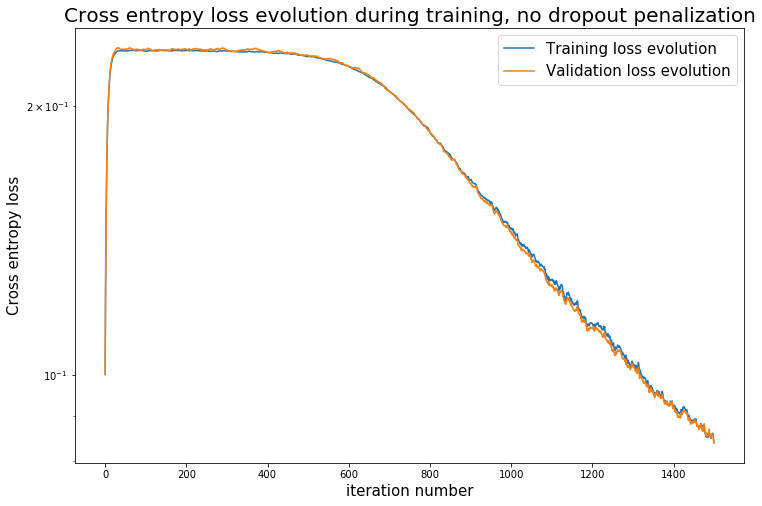

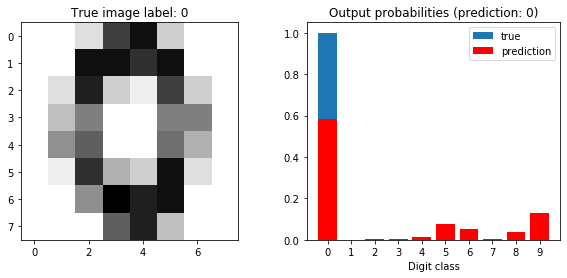

In [16]:
mlp2.plot_loss_history()
mlp2.plot_validation_prediction(12)

In [17]:
mlp3 = MultiLayerPerceptron(X, Y, hidden_size=50, activation='relu', dropout=True, dropout_rate=0.2)
mlp3.train(momentum=True, min_iterations=500, max_iterations=1500, initial_step=1e-1,
              batch_size=64, early_stopping=True, early_stopping_lookbehind=100, early_stopping_delta=1e-4, 
              vectorized=False, flush_history=True, verbose=True)

iteration number: 1	 training loss: 0.4652	validation loss: 0.4646	 validation accuracy: 0.0978
iteration number: 2	 training loss: 0.3596	validation loss: 0.3593	 validation accuracy: 0.0889
iteration number: 3	 training loss: 0.2974	validation loss: 0.2973	 validation accuracy: 0.0978
iteration number: 4	 training loss: 0.2559	validation loss: 0.2561	 validation accuracy: 0.0978
iteration number: 5	 training loss: 0.2268	validation loss: 0.2274	 validation accuracy: 0.0978
iteration number: 6	 training loss: 0.2067	validation loss: 0.2076	 validation accuracy: 0.0978
iteration number: 7	 training loss: 0.1934	validation loss: 0.1946	 validation accuracy: 0.0978
iteration number: 8	 training loss: 0.1859	validation loss: 0.1874	 validation accuracy: 0.0889
iteration number: 9	 training loss: 0.1832	validation loss: 0.1845	 validation accuracy: 0.0889
iteration number: 10	 training loss: 0.1846	validation loss: 0.1859	 validation accuracy: 0.0889
iteration number: 11	 training loss: 0.

iteration number: 86	 training loss: 0.0681	validation loss: 0.0793	 validation accuracy: 0.9067
iteration number: 87	 training loss: 0.0620	validation loss: 0.0766	 validation accuracy: 0.9178
iteration number: 88	 training loss: 0.0663	validation loss: 0.0854	 validation accuracy: 0.9244
iteration number: 89	 training loss: 0.0739	validation loss: 0.0926	 validation accuracy: 0.9044
iteration number: 90	 training loss: 0.0654	validation loss: 0.0830	 validation accuracy: 0.9000
iteration number: 91	 training loss: 0.0580	validation loss: 0.0696	 validation accuracy: 0.9133
iteration number: 92	 training loss: 0.0552	validation loss: 0.0641	 validation accuracy: 0.9311
iteration number: 93	 training loss: 0.0571	validation loss: 0.0683	 validation accuracy: 0.9289
iteration number: 94	 training loss: 0.0607	validation loss: 0.0701	 validation accuracy: 0.9089
iteration number: 95	 training loss: 0.0619	validation loss: 0.0748	 validation accuracy: 0.9178
iteration number: 96	 training

iteration number: 177	 training loss: 0.0381	validation loss: 0.0622	 validation accuracy: 0.9578
iteration number: 178	 training loss: 0.0356	validation loss: 0.0591	 validation accuracy: 0.9489
iteration number: 179	 training loss: 0.0337	validation loss: 0.0589	 validation accuracy: 0.9422
iteration number: 180	 training loss: 0.0314	validation loss: 0.0466	 validation accuracy: 0.9422
iteration number: 181	 training loss: 0.0316	validation loss: 0.0488	 validation accuracy: 0.9333
iteration number: 182	 training loss: 0.0328	validation loss: 0.0489	 validation accuracy: 0.9333
iteration number: 183	 training loss: 0.0308	validation loss: 0.0544	 validation accuracy: 0.9400
iteration number: 184	 training loss: 0.0324	validation loss: 0.0519	 validation accuracy: 0.9422
iteration number: 185	 training loss: 0.0333	validation loss: 0.0522	 validation accuracy: 0.9467
iteration number: 186	 training loss: 0.0365	validation loss: 0.0543	 validation accuracy: 0.9511
iteration number: 18

iteration number: 266	 training loss: 0.0237	validation loss: 0.0482	 validation accuracy: 0.9622
iteration number: 267	 training loss: 0.0204	validation loss: 0.0403	 validation accuracy: 0.9711
iteration number: 268	 training loss: 0.0196	validation loss: 0.0419	 validation accuracy: 0.9733
iteration number: 269	 training loss: 0.0208	validation loss: 0.0428	 validation accuracy: 0.9711
iteration number: 270	 training loss: 0.0260	validation loss: 0.0490	 validation accuracy: 0.9733
iteration number: 271	 training loss: 0.0302	validation loss: 0.0488	 validation accuracy: 0.9644
iteration number: 272	 training loss: 0.0377	validation loss: 0.0531	 validation accuracy: 0.9556
iteration number: 273	 training loss: 0.0384	validation loss: 0.0531	 validation accuracy: 0.9600
iteration number: 274	 training loss: 0.0287	validation loss: 0.0475	 validation accuracy: 0.9667
iteration number: 275	 training loss: 0.0251	validation loss: 0.0456	 validation accuracy: 0.9644
iteration number: 27

iteration number: 357	 training loss: 0.0250	validation loss: 0.0431	 validation accuracy: 0.9733
iteration number: 358	 training loss: 0.0300	validation loss: 0.0475	 validation accuracy: 0.9733
iteration number: 359	 training loss: 0.0329	validation loss: 0.0509	 validation accuracy: 0.9711
iteration number: 360	 training loss: 0.0364	validation loss: 0.0572	 validation accuracy: 0.9644
iteration number: 361	 training loss: 0.0364	validation loss: 0.0558	 validation accuracy: 0.9644
iteration number: 362	 training loss: 0.0304	validation loss: 0.0540	 validation accuracy: 0.9689
iteration number: 363	 training loss: 0.0233	validation loss: 0.0448	 validation accuracy: 0.9711
iteration number: 364	 training loss: 0.0169	validation loss: 0.0355	 validation accuracy: 0.9711
iteration number: 365	 training loss: 0.0108	validation loss: 0.0315	 validation accuracy: 0.9733
iteration number: 366	 training loss: 0.0098	validation loss: 0.0273	 validation accuracy: 0.9733
iteration number: 36

iteration number: 448	 training loss: 0.0143	validation loss: 0.0347	 validation accuracy: 0.9644
iteration number: 449	 training loss: 0.0133	validation loss: 0.0336	 validation accuracy: 0.9622
iteration number: 450	 training loss: 0.0136	validation loss: 0.0302	 validation accuracy: 0.9711
iteration number: 451	 training loss: 0.0123	validation loss: 0.0302	 validation accuracy: 0.9756
iteration number: 452	 training loss: 0.0143	validation loss: 0.0324	 validation accuracy: 0.9800
iteration number: 453	 training loss: 0.0171	validation loss: 0.0358	 validation accuracy: 0.9822
iteration number: 454	 training loss: 0.0202	validation loss: 0.0413	 validation accuracy: 0.9800
iteration number: 455	 training loss: 0.0220	validation loss: 0.0424	 validation accuracy: 0.9711
iteration number: 456	 training loss: 0.0206	validation loss: 0.0424	 validation accuracy: 0.9733
iteration number: 457	 training loss: 0.0207	validation loss: 0.0394	 validation accuracy: 0.9733
iteration number: 45

iteration number: 533	 training loss: 0.0162	validation loss: 0.0377	 validation accuracy: 0.9644
iteration number: 534	 training loss: 0.0165	validation loss: 0.0383	 validation accuracy: 0.9689
iteration number: 535	 training loss: 0.0155	validation loss: 0.0375	 validation accuracy: 0.9822
iteration number: 536	 training loss: 0.0135	validation loss: 0.0355	 validation accuracy: 0.9844
iteration number: 537	 training loss: 0.0139	validation loss: 0.0393	 validation accuracy: 0.9756
iteration number: 538	 training loss: 0.0165	validation loss: 0.0406	 validation accuracy: 0.9756
iteration number: 539	 training loss: 0.0179	validation loss: 0.0411	 validation accuracy: 0.9756
iteration number: 540	 training loss: 0.0166	validation loss: 0.0408	 validation accuracy: 0.9756
iteration number: 541	 training loss: 0.0159	validation loss: 0.0414	 validation accuracy: 0.9711
iteration number: 542	 training loss: 0.0147	validation loss: 0.0415	 validation accuracy: 0.9756
iteration number: 54

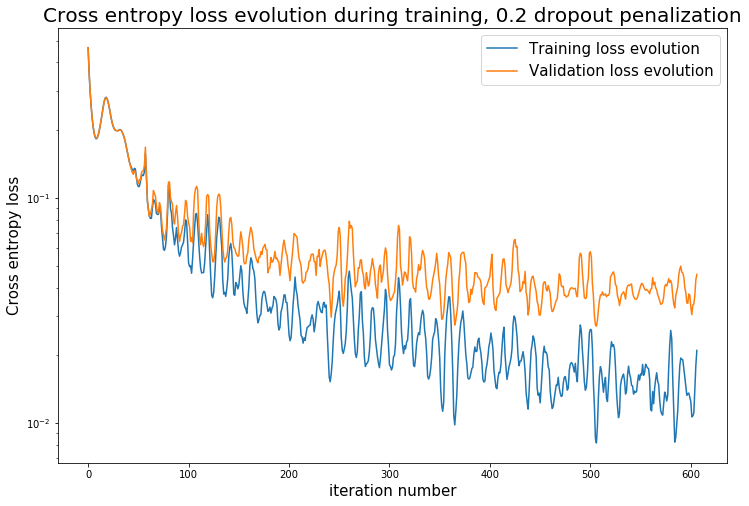

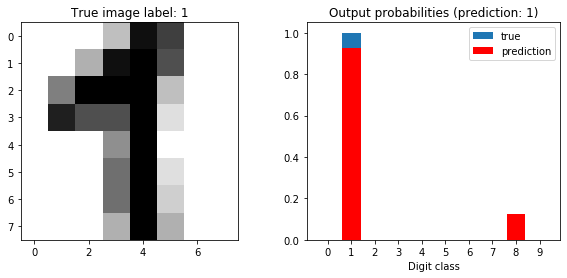

In [21]:
mlp3.plot_loss_history()
mlp3.plot_validation_prediction(12)

## Questions:
#### - Did you succeed to train the MLP and get a high validation accuracy? <br> Display available metrics (training and validation accuracies, training and validation losses)

Yes, it is displayed above

#### - Plot the prediction for a given validation sample. Is it accurate?

Yes it is 

#### - Compare the full gradient descent with the SGD.

I didn't understand the question 

#### - Play with the hyper parameters you have: the hidden size, the activation function, the initial step and the batch size. <br> Comment. Don't hesitate to visualize results.
#### - Once properly implemented, compare the training using early stopping, dropout, or both of them. <br> Why are these methods useful here?

Using early stopping is reducing the time for the model, assuming more iterations will be useless.

#### - Once properly implemented, compare the training using momentum.

It is much faster using momentum

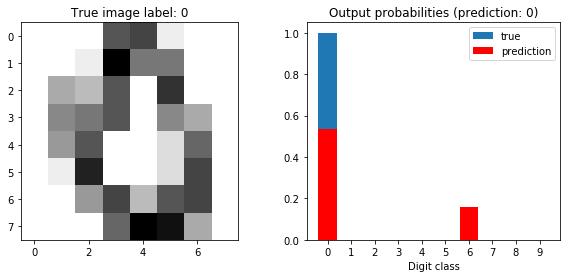

In [19]:
mlp.plot_validation_prediction(sample_id=42)

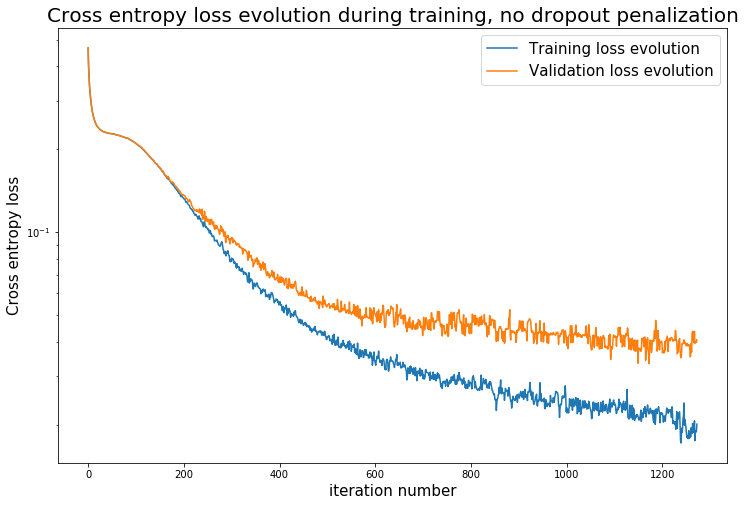

In [20]:
mlp.plot_loss_history()

# III - Multiclass classification MLP with Keras

#### - Implement the same network architecture with Keras;
    - First using the Sequential API
    - Secondly using the functional API

#### - Check that the Keras model can approximately reproduce the behavior of the Numpy model.

#### - Compute the negative log likelihood of a sample 42 in the test set (can use `model.predict_proba`).

#### - Compute the average negative log-likelihood on the full test set.

#### - Compute the average negative log-likelihood  on the full training set and check that you can get the value of the loss reported by Keras.

#### - Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 500 or more if necessary).

In [22]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y)
scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
X_tr = scaler.fit_transform(X_tr)
X_val = scaler.transform(X_val)

In [23]:
n_features = X[0].shape[0]
n_classes = len(np.unique(Y_tr))
n_hidden = 10

### Sequential

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))
keras_model = Sequential()
# TODO:
keras_model.add(Dense(n_hidden, input_dim=n_features, activation=activation))
keras_model.add(Dense(n_classes, activation='softmax'))

keras_model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Convert labels to categorical one-hot encoding
c_Y_tr = to_categorical(Y_tr, num_classes=n_classes)
c_Y_val = to_categorical(Y_val, num_classes=n_classes)

keras_model.fit(
    X_tr, c_Y_tr,
    epochs=80, batch_size=64, verbose=True,
    validation_data=(X_val, c_Y_val)
)

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/80
1347/1347 [==============================] - 1s 410us/step - loss: 2.2534 - acc: 0.1975 - val_loss: 2.1925 - val_acc: 0.2444
Epoch 2/80
1347/1347 [==============================] - 0s 21us/step - loss: 2.1542 - acc: 0.2739 - val_loss: 2.1080 - val_acc: 0.3311
Epoch 3/80
1347/1347 [==============================] - 0s 21us/step - loss: 2.0762 - acc: 0.3073 - val_loss: 2.0336 - val_acc: 0.3556
Epoch 4/80
1347/1347 [==============================] - 0s 24us/step - loss: 2.0012 - acc: 0.3571 - val_loss: 1.9619 - val_acc: 0.4111
Epoch 5/80
1347/1347 [==============================] - 0s 23us/step - loss: 1.9293 - acc: 0.3846 - val_loss: 1.8844 - val_acc: 0.4578
Epoch 6/80
1347/1347 [==============================] - 0s 24us/step - loss: 1.8520 - acc: 0.4276 - val_loss: 1.8052 - val_acc: 0.4889
Epoch 7/80
1347/1347 [==============================] - 0s 23us/step - loss: 1.7719 - acc: 0.4729 - val_loss: 1.722

Epoch 61/80
1347/1347 [==============================] - 0s 41us/step - loss: 0.1664 - acc: 0.9636 - val_loss: 0.2062 - val_acc: 0.9511
Epoch 62/80
1347/1347 [==============================] - 0s 39us/step - loss: 0.1628 - acc: 0.9651 - val_loss: 0.2036 - val_acc: 0.9533
Epoch 63/80
1347/1347 [==============================] - 0s 38us/step - loss: 0.1600 - acc: 0.9651 - val_loss: 0.2003 - val_acc: 0.9533
Epoch 64/80
1347/1347 [==============================] - 0s 39us/step - loss: 0.1570 - acc: 0.9651 - val_loss: 0.1941 - val_acc: 0.9511
Epoch 65/80
1347/1347 [==============================] - 0s 35us/step - loss: 0.1536 - acc: 0.9666 - val_loss: 0.1963 - val_acc: 0.9533
Epoch 66/80
1347/1347 [==============================] - 0s 37us/step - loss: 0.1513 - acc: 0.9681 - val_loss: 0.1913 - val_acc: 0.9533
Epoch 67/80
1347/1347 [==============================] - 0s 37us/step - loss: 0.1489 - acc: 0.9659 - val_loss: 0.1954 - val_acc: 0.9578
Epoch 68/80
1347/1347 [=========================

In [54]:
def negll(Y_val, X_val, i, verbose=False):
    
    true_Y = to_categorical(Y_val[i], num_classes=n_classes)
    if verbose : print(true_Y)
    inter = np.expand_dims(X_val[i], axis=0)
    if verbose : print(inter)
    inter2 = keras_model.predict_proba(inter)
    if verbose : print(inter2)
    pred_Y = np.squeeze(inter2)
    if verbose : print(pred_Y)
    neg_log = -np.log(true_Y.dot(pred_Y))
    
    return neg_log
    
i = 42
print("Negative loglikelihood:" +str(negll(Y_val, X_val, i)))

Negative loglikelihood:0.057472404


In [57]:
count, summ = 0,0

for i in range(1, len(Y_tr)):
    summ += negll(Y_tr, X_tr, i)
    count +=1

av_nll = summ/count
print("Average negative log likelihood : " +str(av_nll))

Average negative log likelihood : 0.12128374554589806


### Functional

In [32]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

activation = "relu"
# activation = "sigmoid"

print('Model with {} activation'.format(activation))

inputs = Input(shape=(n_features,))
# TODO:
h = Dense(n_hidden, activation=activation)(inputs)
o = Dense(n_classes, activation='softmax')(h)

model = Model(inputs=inputs, outputs=o)
model.compile(
    optimizer='rmsprop',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(
    X_tr, c_Y_tr, 
    epochs=80, verbose=1, batch_size=32,
    validation_data=(X_val,c_Y_val))

Model with relu activation
Train on 1347 samples, validate on 450 samples
Epoch 1/80
1347/1347 [==============================] - 1s 419us/step - loss: 2.3354 - acc: 0.1106 - val_loss: 2.2438 - val_acc: 0.1444
Epoch 2/80
1347/1347 [==============================] - 0s 67us/step - loss: 2.1829 - acc: 0.1967 - val_loss: 2.1379 - val_acc: 0.2489
Epoch 3/80
1347/1347 [==============================] - 0s 76us/step - loss: 2.0918 - acc: 0.2472 - val_loss: 2.0537 - val_acc: 0.2844
Epoch 4/80
1347/1347 [==============================] - 0s 74us/step - loss: 2.0071 - acc: 0.2673 - val_loss: 1.9660 - val_acc: 0.2844
Epoch 5/80
1347/1347 [==============================] - 0s 76us/step - loss: 1.9129 - acc: 0.2814 - val_loss: 1.8701 - val_acc: 0.3000
Epoch 6/80
1347/1347 [==============================] - 0s 44us/step - loss: 1.8151 - acc: 0.2903 - val_loss: 1.7715 - val_acc: 0.3133
Epoch 7/80
1347/1347 [==============================] - 0s 70us/step - loss: 1.7159 - acc: 0.3185 - val_loss: 1.670

Epoch 61/80
1347/1347 [==============================] - 0s 61us/step - loss: 0.1394 - acc: 0.9629 - val_loss: 0.1886 - val_acc: 0.9511
Epoch 62/80
1347/1347 [==============================] - 0s 69us/step - loss: 0.1368 - acc: 0.9666 - val_loss: 0.1846 - val_acc: 0.9489
Epoch 63/80
1347/1347 [==============================] - 0s 69us/step - loss: 0.1344 - acc: 0.9659 - val_loss: 0.1822 - val_acc: 0.9511
Epoch 64/80
1347/1347 [==============================] - 0s 69us/step - loss: 0.1316 - acc: 0.9651 - val_loss: 0.1831 - val_acc: 0.9489
Epoch 65/80
1347/1347 [==============================] - 0s 67us/step - loss: 0.1295 - acc: 0.9703 - val_loss: 0.1800 - val_acc: 0.9533
Epoch 66/80
1347/1347 [==============================] - 0s 68us/step - loss: 0.1268 - acc: 0.9681 - val_loss: 0.1789 - val_acc: 0.9533
Epoch 67/80
1347/1347 [==============================] - 0s 68us/step - loss: 0.1255 - acc: 0.9688 - val_loss: 0.1812 - val_acc: 0.9511
Epoch 68/80
1347/1347 [=========================

#### Now that you know if the model is underfitting or overfitting:

It doesn't seems that the model is overfitting or underfitting, each time validation and training accuracy are near (<2% deviation). 

#### - In case of underfitting, can you explain why ? Also change the structure of the 2 previous networks to cancell underfitting
#### - In case of overfitting, explain why and change the structure of the 2 previous networks to cancell the overfitting